<a href="https://colab.research.google.com/github/Lyu-Sterkh/Sentiment-analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 4.2 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import torch
import nltk
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('wordnet')
from wordcloud import WordCloud
from tqdm.notebook import tqdm
import string
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import softmax
import re
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Google Drive

In [4]:
# Google Drive mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read in Data

In [22]:
df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
#df.dropna(axis=0, how='any', inplace=True)

# EDA

## Data observing

In [6]:
df.shape

(568454, 10)

In [23]:
df = df.head(5000)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      5000 non-null   int64 
 1   ProductId               5000 non-null   object
 2   UserId                  5000 non-null   object
 3   ProfileName             5000 non-null   object
 4   HelpfulnessNumerator    5000 non-null   int64 
 5   HelpfulnessDenominator  5000 non-null   int64 
 6   Score                   5000 non-null   int64 
 7   Time                    5000 non-null   int64 
 8   Summary                 5000 non-null   object
 9   Text                    5000 non-null   object
dtypes: int64(5), object(5)
memory usage: 390.8+ KB


In [ ]:
#df.isna().sum()

In [ ]:
#df.dropna(axis=0, inplace=True)
#df.isna().sum()

In [ ]:
#df.shape

In [9]:
df.nunique()

Id                        5000
ProductId                  731
UserId                    4804
ProfileName               4689
HelpfulnessNumerator        44
HelpfulnessDenominator      47
Score                        5
Time                      1630
Summary                   4566
Text                      4984
dtype: int64

In [10]:
df.columns.values.tolist()

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

In [11]:
duplicateRows = df[df.duplicated(['Text'])]
duplicateRows.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
1973,1974,B0017165OG,A2EPNS38TTLZYN,tedebear,0,0,3,1312675200,Pok Chops,The pork chops from Omaha Steaks were very tas...
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,2,1127606400,Below standard,Too much of the white pith on this orange peel...
2336,2337,B0001FQVCK,A5D06XJHDXK75,C. Po,1,1,5,1190592000,"Baci's are pure heaven - great gift, stocking ...",My family has been in love with Baci's ever si...
2647,2648,B0016FY6H6,A2NLZ3M0OJV9NX,Mark Bodzin,0,0,2,1313107200,way too weak for my tastes,"What can i say, I love iced tea. I drink a lot..."
2653,2654,B0016FY6H6,A3I4PCBRENJNG2,L. Cain,0,0,4,1300579200,quality lightly sweetened green tea powder,lots of uses for this green tea...<br /><br />...
2946,2947,B0002TJAZK,A2ISKAWUPGGOLZ,M. S. Handley,0,1,1,1310774400,Kitty Junk Food,We have five cats - one an elderly cat of 15 y...


In [24]:
df.drop_duplicates(subset='Text', inplace = True)

In [13]:
df.shape

(4984, 10)

In [14]:
df[df.duplicated(['Text'])].sum()

Id                        0.0
ProductId                 0.0
UserId                    0.0
ProfileName               0.0
HelpfulnessNumerator      0.0
HelpfulnessDenominator    0.0
Score                     0.0
Time                      0.0
Summary                   0.0
Text                      0.0
dtype: float64

In [25]:
df = df.drop(columns=['UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'ProductId', 'Summary'], axis=1)
df.head()

,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...


In [26]:
#df = df.to_csv('/content/drive/MyDrive/DS/ВКР/NLP/df.csv')

### Visualisation

In [ ]:
df['Score'].value_counts().sort_index()

1     467
2     287
3     393
4     711
5    3126
Name: Score, dtype: int64

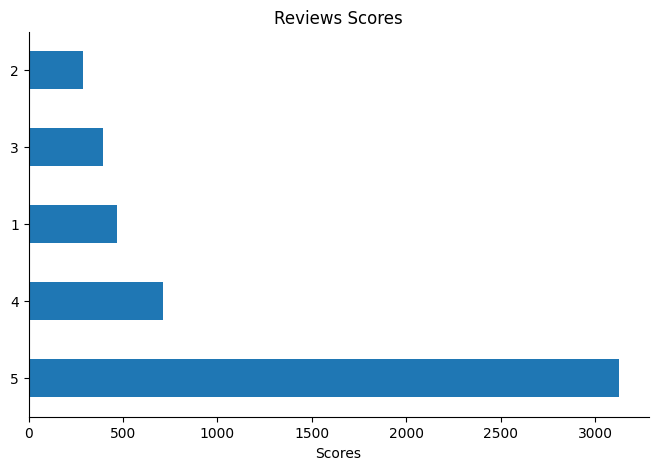

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

df['Score'].value_counts()\
    .plot(kind='barh', 
          title='Reviews Scores', 
          figsize=(8, 5))
plt.xlabel('Scores')
ax.spines[['right', 'top']].set_visible(False)
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scors_Bar.jpeg')
plt.show()

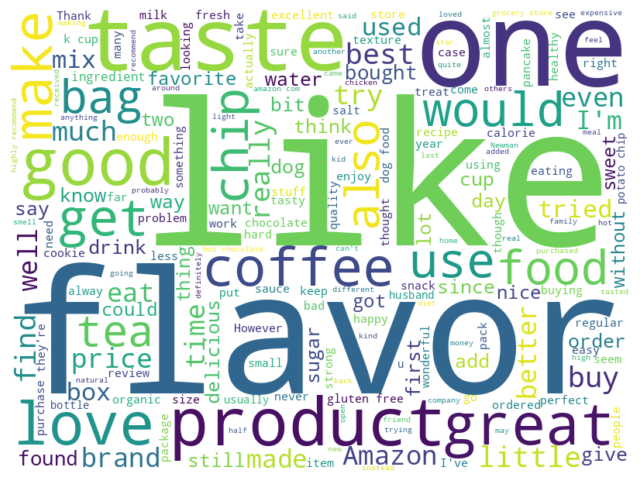

In [ ]:
# Create a word cloud of the 'Text' column
text = ' '.join(df['Text'].astype(str).tolist())
wordcloud = WordCloud(
    width=800, 
    height=600, 
    background_color='white').generate(text) # stopwords=stopwords1
    
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/wordcloud_gen.jpeg')
plt.show()

## NLTK. Text preprocessing

In [5]:
nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Tokenize

In [20]:
tokenizer = RegexpTokenizer(r'\w+')

In [21]:
df['tokens'] = df['Text'].apply(tokenizer.tokenize)

In [22]:
df['tokens'].iloc[25]

['Product',
 'received',
 'is',
 'as',
 'advertised',
 'br',
 'br',
 'a',
 'href',
 'http',
 'www',
 'amazon',
 'com',
 'gp',
 'product',
 'B001GVISJM',
 'Twizzlers',
 'Strawberry',
 '16',
 'Ounce',
 'Bags',
 'Pack',
 'of',
 '6',
 'a']

### Stopwords

In [6]:
#df = pd.read_csv('/content/drive/MyDrive/DS/ВКР/NLP/df.csv', index_col='Unnamed: 0')

In [7]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [12]:
stop_words = stopwords.words('english')
stop_words.extend(['br', 'href'])

In [13]:
print(pd.DataFrame(stop_words))

            0
0           i
1          me
2          my
3      myself
4          we
..        ...
176     won't
177    wouldn
178  wouldn't
179        br
180      href

[181 rows x 1 columns]


In [21]:
def df_preprocess(text):
    text = text.lower()
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', 'site', text)
    text = re.sub('@[^\s]+', 'user', text)
    text = re.sub('[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]', ' ', text)
    text = re.sub('[^A-Za-z]', ' ', text)
    stemmer = SnowballStemmer("english")
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text

In [12]:
df['Text'].iloc[25]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [15]:
df['Text'].iloc[575]

"I've found a new taste treat. I'm not a big one for potato chips, so I am sure I've come late to discover these. I think they are really good.  The processing & ingredients list is actually pretty good-no trans fats, etc. So, if you want an indulgence, these are A+ !  They are thicker & more tasty than the mass produced potato chips we've all come to know.  They are much more flavorful.  Never had a honey-dijon potato chip before. Incredibly good & a flavorful combination of sweet, tangy, salty. Also not overly hot or spicy. Excellent!<br /><br />If you want a snack, have something REALLY good. It's got to be worth the calories-and these are!"

In [22]:
df['Text'] = df['Text'].apply(df_preprocess)

In [23]:
df['Text'].iloc[25]

'product receiv advertis site strawberri ounc bag pack'

In [24]:
df['Text'].iloc[575]

'found new tast treat big one potato chip sure come late discov think realli good process ingredi list actual pretti good tran fat etc want indulg thicker tasti mass produc potato chip come know much flavor never honey dijon potato chip incred good flavor combin sweet tangi salti also over hot spici excel want snack someth realli good got worth calori'

In [25]:
df.sample(10)

,Id,Score,Text
4828,4829,5,two small dog took food immedi well fact move ...
1342,1343,5,dress becam instant favorit mine fat free with...
2874,2875,4,found coffe flavor bold experi bitter refer pu...
4277,4278,5,gritti like lot gf mix make whole box keep fri...
2926,2927,5,love oreo cooki mani us well rememb school sna...
4646,4647,5,thank amazon carri wonder product local grocer...
3414,3415,2,site mountain hot cocoa perpetu stock winter t...
1301,1302,5,husband beer nut lover look mani store could f...
4860,4861,5,research compani research ingredi custom servi...
2194,2195,4,ador brand peanut satay noodl unlik ethnic foo...


In [27]:
df_for_bert = df
#df_for_bert.to_csv('/content/drive/MyDrive/DS/ВКР/NLP/df_for_bert.csv')

In [51]:
df_for_bert.head()

,Id,Score,Text
0,1,5,bought several vitality canned dog food produc...
1,2,1,product arrived labeled jumbo salted peanut pe...
2,3,4,confection around century light pillowy citrus...
3,4,2,looking secret ingredient robitussin believe f...
4,5,5,great taffy great price wide assortment yummy ...


In [28]:
df = df.drop(columns=['Id'], axis=1)
df.head()

,Score,Text
0,5,bought sever vital can dog food product found ...
1,1,product arriv label jumbo salt peanut peanut a...
2,4,confect around centuri light pillowi citrus ge...
3,2,look secret ingredi robitussin believ found go...
4,5,great taffi great price wide assort yummi taff...


In [29]:
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)
df.head()

<ipython-input-29-75443bfb325e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Score,Text,sentiment
0,5,bought sever vital can dog food product found ...,1
1,1,product arriv label jumbo salt peanut peanut a...,-1
2,4,confect around centuri light pillowi citrus ge...,1
3,2,look secret ingredi robitussin believ found go...,-1
4,5,great taffi great price wide assort yummi taff...,1


### Tokenize

! Just for ex. Done before in regex

In [11]:
df['Text'].iloc[25]

'Product received is as advertised.<br /><br /><a href="http://www.amazon.com/gp/product/B001GVISJM">Twizzlers, Strawberry, 16-Ounce Bags (Pack of 6)</a>'

In [12]:
tokens = nltk.word_tokenize(df['Text'].iloc[25])
tokens

['Product',
 'received',
 'is',
 'as',
 'advertised.',
 '<',
 'br',
 '/',
 '>',
 '<',
 'br',
 '/',
 '>',
 '<',
 'a',
 'href=',
 "''",
 'http',
 ':',
 '//www.amazon.com/gp/product/B001GVISJM',
 "''",
 '>',
 'Twizzlers',
 ',',
 'Strawberry',
 ',',
 '16-Ounce',
 'Bags',
 '(',
 'Pack',
 'of',
 '6',
 ')',
 '<',
 '/a',
 '>']

In [ ]:
#tagged = nltk.pos_tag(tokens)
#tagged[:10]

[('My', 'PRP$'),
 ('daughter', 'NN'),
 ('loves', 'VBZ'),
 ('twizzlers', 'NNS'),
 ('and', 'CC'),
 ('this', 'DT'),
 ('shipment', 'NN'),
 ('of', 'IN'),
 ('six', 'CD'),
 ('pounds', 'NNS')]

In [ ]:
#nltk_pos = pd.read_excel('/content/drive/MyDrive/DS/ВКР/NLP/NLTK_pos_tags.xlsx')
#nltk_pos

,Abbreviation,Meaning
0,CC,coordinating conjunction
1,CD,cardinal digit
2,DT,determiner
3,EX,existential there
4,FW,foreign word
5,IN,preposition/subordinating conjunction
6,JJ,This NLTK POS Tag is an adjective (large)
7,JJR,"adjective, comparative (larger)"
8,JJS,"adjective, superlative (largest)"
9,LS,list market


In [ ]:
# Identify POS of words
#entities = nltk.chunk.ne_chunk(tagged)
#entities.pprint()

(S
  My/PRP$
  daughter/NN
  loves/VBZ
  twizzlers/NNS
  and/CC
  this/DT
  shipment/NN
  of/IN
  six/CD
  pounds/NNS
  really/RB
  hit/VBD
  the/DT
  spot/NN
  ./.
  It/PRP
  's/VBZ
  exactly/RB
  what/WP
  you/PRP
  would/MD
  expect/VB
  .../:
  six/CD
  packages/NNS
  of/IN
  strawberry/NN
  twizzlers/NNS
  ./.)


# Train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df['Text'], df['Score'], 
                                                    train_size=0.6, test_size=0.4,
                                                    random_state=73)

In [31]:
type(X_train)

pandas.core.series.Series

In [32]:
X_train[100]

'mouth say love thee let count way like appl product must item draw back ship cost heavi'

In [33]:
y_train[100]

5

# Vectorization

## BOW

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english")

In [45]:
X_train_BOW = vectorizer.fit_transform(X_train)
X_test_BOW = vectorizer.transform(X_test)

In [46]:
print(X_train_BOW.shape, X_test_BOW.shape)

(2754, 6828) (1837, 6828)


In [37]:
X_train.iloc[100]

'husband grandaught love cocoa make time drink coffe husband picki person reason realli like one product want keep stock hous love night dinner cold even'

In [38]:
X_train_BOW[100]

<1x7610 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

## TF-IDF

In [39]:
from sklearn.feature_extraction.text import  TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english")

In [47]:
X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

In [48]:
print(X_train_TFIDF.shape, X_test_TFIDF.shape)

(2754, 6828) (1837, 6828)


In [42]:
X_train_TFIDF[100]

<1x7610 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

# Scores' prediction

## GaussianNB

In [49]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
result_bayes = nb.fit(X_train_BOW.toarray(), y_train)
nb.score(X_test_BOW.toarray(),y_test)

0.4518236254763201

## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
result_logreg = logreg.fit(X_train_BOW, y_train)
logreg.score(X_test_BOW,y_test)

0.7033206314643441

## SVM

In [51]:
from sklearn import svm
metodsvm = svm.SVC()
result_svm = metodsvm.fit(X_train_BOW, y_train)
metodsvm.score(X_test_BOW, y_test)

0.6875340228633642

# Tweets classification

In [71]:
df_for_bert.head()

,Id,Score,Text
0,1,5,bought several vitality canned dog food produc...
1,2,1,product arrived labeled jumbo salted peanut pe...
2,3,4,confection around century light pillowy citrus...
3,4,2,looking secret ingredient robitussin believe f...
4,5,5,great taffy great price wide assortment yummy ...


## VADER 

( Valence Aware Dictionary for Sentiment Reasoning) is an NLTK module that provides sentiment scores based on the words used. It is a rule-based sentiment analyzer in which the terms are generally labeled as per their semantic orientation as either positive or negative.

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:<br>
Stop words are removed<br>
each word is scored and combined to a total score.

In [55]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('Live long and prosper!')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
sia.polarity_scores('burn in hell!')

{'neg': 0.71, 'neu': 0.29, 'pos': 0.0, 'compound': -0.7088}

In [56]:
example1 = df_for_bert['Text'].iloc[30]
example1

'offer great price great taste thanks amazon selling product staral'

In [57]:
sia.polarity_scores(example1)

{'neg': 0.0, 'neu': 0.319, 'pos': 0.681, 'compound': 0.9153}

In [58]:
example2 = df_for_bert['Text'].iloc[60]
example2

'bag candy online pretty expensive cheaper order compete grocery store good combination favorite candy'

In [59]:
sia.polarity_scores(example2)

{'neg': 0.0, 'neu': 0.547, 'pos': 0.453, 'compound': 0.8442}

In [76]:
# Run the polarity score on the entire dataset
res_vader = {}
for i, row in tqdm(df_for_bert.iterrows(), total=len(df_for_bert)):
    text = row['Text']
    df_id = row['Id']
    res_vader[df_id] = sia.polarity_scores(text)

  0%|          | 0/4984 [00:00<?, ?it/s]

In [61]:
vaders = pd.DataFrame(res_vader)

In [62]:
vaders.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
neg,0.0000,0.1290,0.1320,0.0000,0.0000,0.0440,0.0000,0.0000,0.0000,0.0000,...,0.000,0.0000,0.1380,0.000,0.0880,0.0470,0.0000,0.0550,0.1390,0.0700
neu,0.5170,0.7620,0.5760,0.8540,0.3690,0.6590,0.5590,0.2870,0.7040,0.5850,...,0.267,0.7370,0.8040,0.465,0.6530,0.6930,0.6610,0.6540,0.4500,0.5330
pos,0.4830,0.1100,0.2920,0.1460,0.6310,0.2970,0.4410,0.7130,0.2960,0.4150,...,0.733,0.2630,0.0580,0.535,0.2590,0.2600,0.3390,0.2920,0.4110,0.3960
compound,0.9413,-0.1027,0.8624,0.4404,0.9468,0.9136,0.9463,0.9313,0.6369,0.8176,...,0.929,0.6908,-0.5106,0.967,0.7184,0.9127,0.9812,0.9207,0.9804,0.9792


In [63]:
vaders = vaders.T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df_for_bert, how='left')

In [64]:
vaders.head()

,Id,neg,neu,pos,compound,Score,Text
0,1,0.000,0.517,0.483,0.9413,5,bought several vitality canned dog food produc...
1,2,0.129,0.762,0.110,-0.1027,1,product arrived labeled jumbo salted peanut pe...
2,3,0.132,0.576,0.292,0.8624,4,confection around century light pillowy citrus...
3,4,0.000,0.854,0.146,0.4404,2,looking secret ingredient robitussin believe f...
4,5,0.000,0.369,0.631,0.9468,5,great taffy great price wide assortment yummy ...


In [65]:
df['Text'].iloc[0]

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better la ador finicky appreciates product better'

### VADER results visualisation

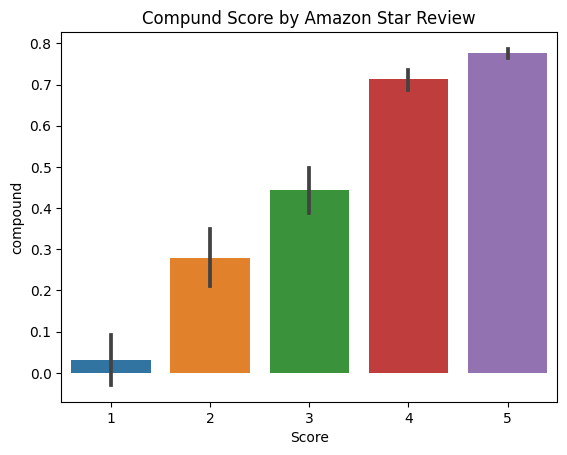

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Compund Score by Amazon Star Review.jpeg')
plt.show()

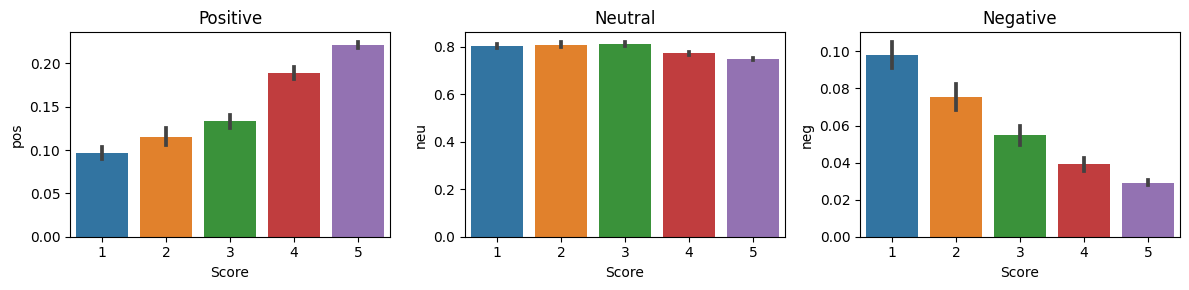

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Scores by Amazon Star Review.jpeg')
plt.show()

## Roberta Pretrained Model

Use a model trained of a large corpus of data.

Transformer model accounts for the words but also the context related to other words.

In [66]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [67]:
example = df_for_bert['Text'].iloc[0]
example

'bought several vitality canned dog food product found good quality product look like stew processed meat smell better la ador finicky appreciates product better'

In [68]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.006078339, 'roberta_neu': 0.071591385, 'roberta_pos': 0.9223303}


In [69]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [77]:
res_roberta = {}
for i, row in tqdm(df_for_bert.iterrows(), total=len(df_for_bert)):
    try:
        text = row['Text']
        df_id = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res_roberta[df_id] = both
    except RuntimeError:
        print(f'Broke for id {df_id}')

  0%|          | 0/4984 [00:00<?, ?it/s]

Broke for id 540
Broke for id 1321
Broke for id 1498
Broke for id 2248


In [78]:
results_df = pd.DataFrame(res_roberta)
results_df.head()

,1,2,3,4,5,6,7,8,9,10,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
vader_neg,0.000000,0.129000,0.132000,0.000000,0.000000,0.044000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.138000,0.000000,0.088000,0.047000,0.000000,0.055000,0.139000,0.07000
vader_neu,0.517000,0.762000,0.576000,0.854000,0.369000,0.659000,0.559000,0.287000,0.704000,0.58500,...,0.267000,0.737000,0.804000,0.465000,0.653000,0.693000,0.661000,0.654000,0.450000,0.53300
vader_pos,0.483000,0.110000,0.292000,0.146000,0.631000,0.297000,0.441000,0.713000,0.296000,0.41500,...,0.733000,0.263000,0.058000,0.535000,0.259000,0.260000,0.339000,0.292000,0.411000,0.39600
vader_compound,0.941300,-0.102700,0.862400,0.440400,0.946800,0.913600,0.946300,0.931300,0.636900,0.81760,...,0.929000,0.690800,-0.510600,0.967000,0.718400,0.912700,0.981200,0.920700,0.980400,0.97920
roberta_neg,0.006078,0.095526,0.003831,0.005513,0.001966,0.002539,0.002165,0.001913,0.013234,0.00697,...,0.001933,0.011229,0.703758,0.001645,0.248915,0.109453,0.002344,0.016655,0.037073,0.06546


In [79]:
results_df = results_df.T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df_for_bert, how='left')

In [80]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,Text
0,1,0.000,0.517,0.483,0.9413,0.006078,0.071591,0.922330,5,bought several vitality canned dog food produc...
1,2,0.129,0.762,0.110,-0.1027,0.095526,0.839240,0.065234,1,product arrived labeled jumbo salted peanut pe...
2,3,0.132,0.576,0.292,0.8624,0.003831,0.103483,0.892686,4,confection around century light pillowy citrus...
3,4,0.000,0.854,0.146,0.4404,0.005513,0.342440,0.652047,2,looking secret ingredient robitussin believe f...
4,5,0.000,0.369,0.631,0.9468,0.001966,0.012693,0.985340,5,great taffy great price wide assortment yummy ...


## Compare Scores between models

In [ ]:
results_df.columns.to_list()

['Id',
 'vader_neg',
 'vader_neu',
 'vader_pos',
 'vader_compound',
 'roberta_neg',
 'roberta_neu',
 'roberta_pos',
 'ProductId',
 'Score',
 'Summary',
 'Text']

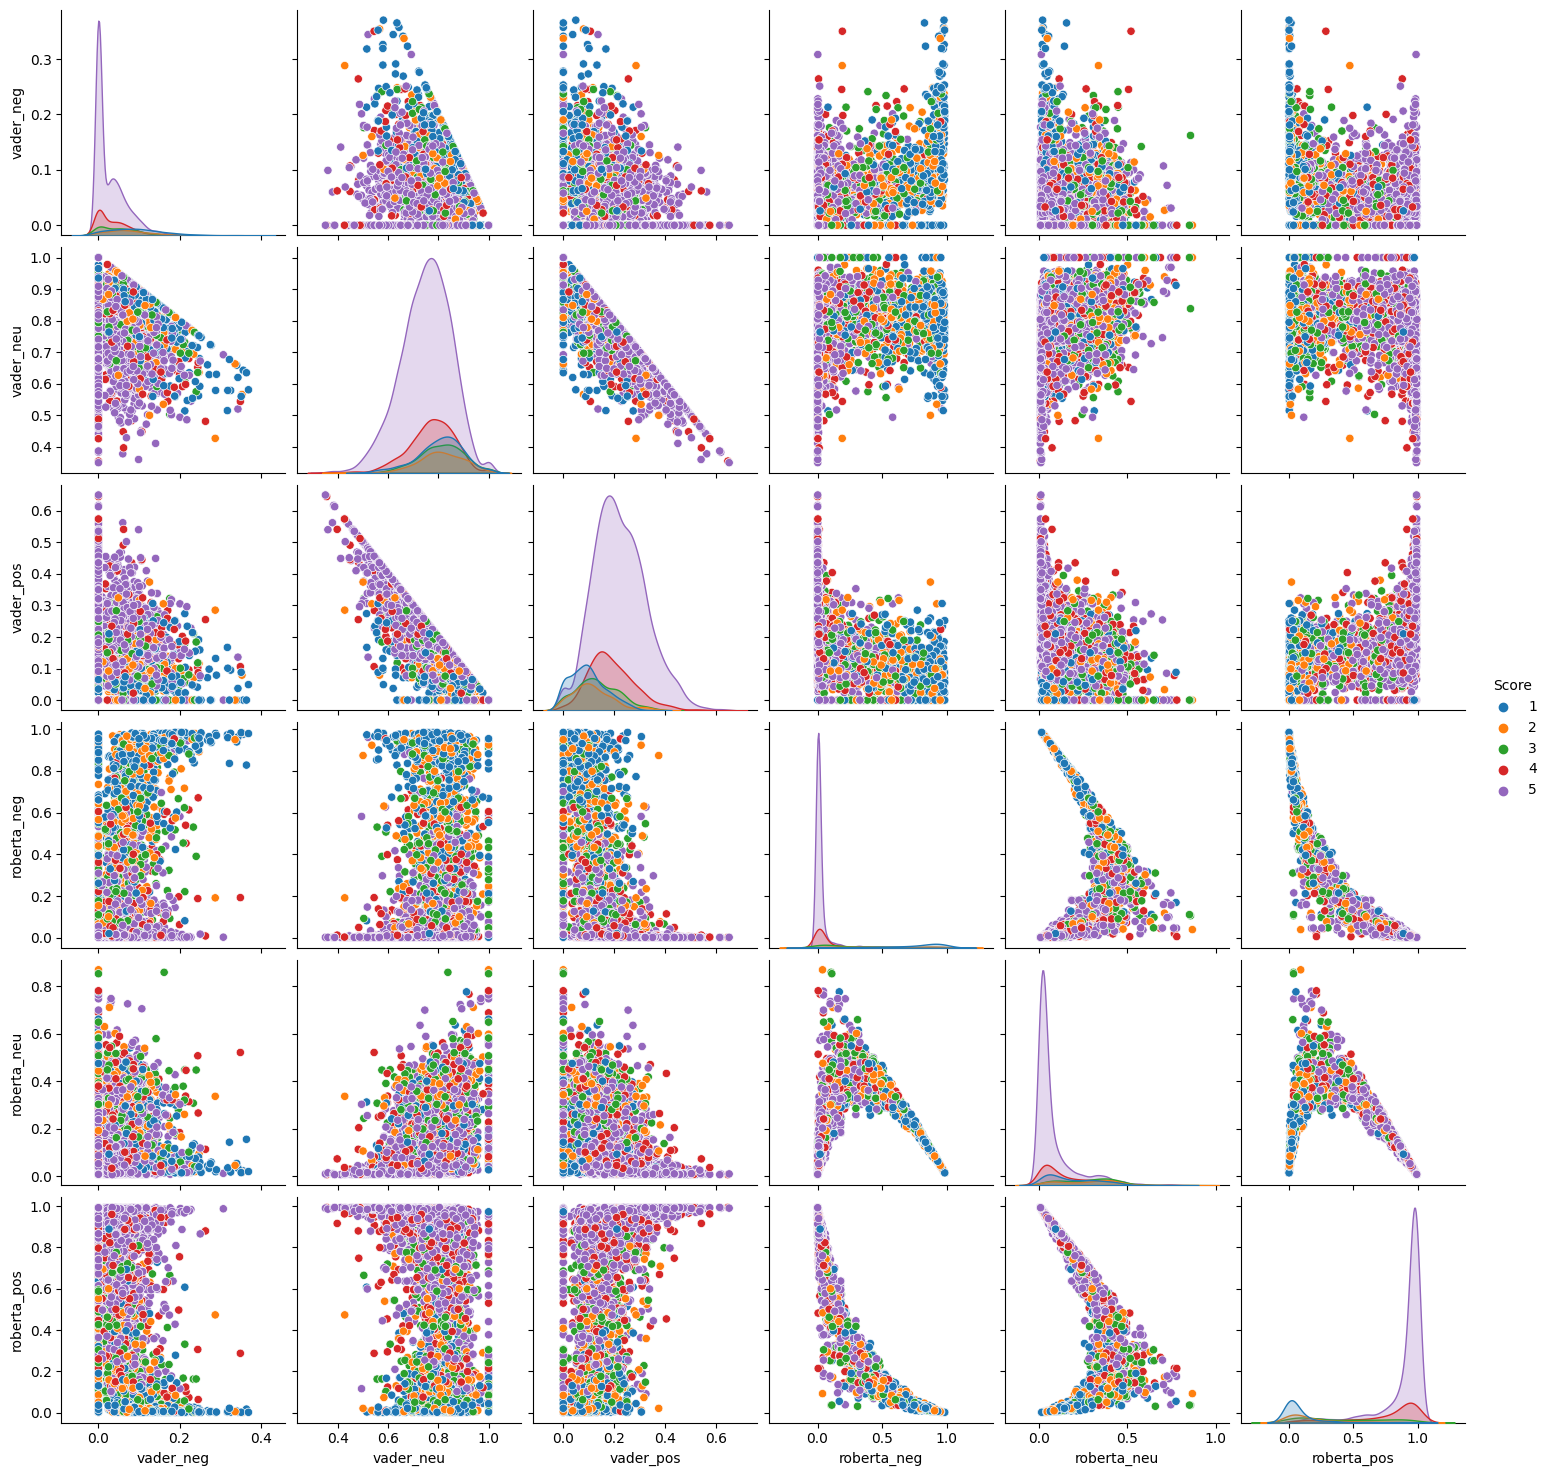

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
#plt.savefig('/content/drive/MyDrive/DS/ВКР/NLP/Vader_Roberta_comparison.jpeg')
plt.show()

## Loss examples
Lets look at some examples where the model scoring and review score differ the most.

Positive 1-Star and Negative 5-Star Reviews

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[5]

'This has to be without a doubt the WORST tasting Hot Chocolate ever! The best way to describe the taste of "This Stuff" is really cheap suger free instant hot chocolate. Swiss Miss instant is way better and cost less. After only 3 cups threw the rest in the garbage where it belongs and canceled my subscribe and save for this "SLOP"!'

# ЧЕРНОВИК

## r score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(data['polarity'], data['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(data['polarity'], data['vader_prediction']))